# Synthetic Domain Examples #

In this notebook, we will use a synthetic environment MDP along with specifications expressed as a belief over LTL formulas. We will examine how the choice of the evaluation criteria affects the nature of task executions generated by a planner optimizing that criterion.


Import all the required libraries and define some helper function we will use in the code later


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import pygraphviz as pgv
from utils import *
from LearningAgents import *
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20,20]


In [2]:
MDPCreator = {}
MDPCreator[1] = CreateSpecMDP1
MDPCreator[2] = CreateSpecMDP2
MDPCreator[3] = CreateSpecMDP3
MDPCreator[4] = CreateSpecMDP4


def TrainAndEvalMDP(IDx, key, risk_level = 0.3, prog='neato', print_terminal = False):
    MDPFunction = MDPCreator[IDx]
    MDP, fsm, cmdp = MDPFunction(reward_type = key, risk_level = risk_level)
    q_agent = QLearningAgent(MDP)
    q_agent.explore(episode_limit = 1000, verbose = True)
    stoch_eval = ExplorerAgent(MDP, input_policy=q_agent.create_learned_softmax_policy(0.02))
    stoch_eval.explore(episode_limit = 1000, verbose = True)
    print('\n')
    VisualizeExploration(stoch_eval, prog = prog)
    print('Size of the specification FSM: ', len(MDP.specification_fsm.states2id))
    print('Formulas considered: ', len(MDP.specification_fsm._formulas))
    
    r = [record[-1][3] for record in stoch_eval.episodic_record]
    if print_terminal:
        print('Average terminal reward: ', np.mean(r))
        print('Median terminal reward: ', np.median(r))
    return q_agent, stoch_eval, MDP


def LabelNode(node):
    cmdp_state = node[1]
    threats = cmdp_state[0]
    waypoints = cmdp_state[1::]
    label = 'S'
    if threats: 
        label = 'T0'
    else:
        for (i,val) in enumerate(waypoints):
            if val: label = f'W{i}'

    return label

def VisualizeExploration(Learner:ExplorerAgent, prog = 'neato'):
    G = Learner.G
    NodeLabels = {}
    for node in G.nodes:
        NodeLabels[node] = LabelNode(node)
        
    pos = nx.drawing.nx_agraph.graphviz_layout(G, prog = prog)
    nx.draw_networkx(G, pos, node_size = 12500, width = 2.5, with_labels = False, arrowsize=40)
    _ = nx.draw_networkx_labels(G, pos, NodeLabels, font_size = 32, font_color='w')
    plt.box(False)
    


Consider a simple discrete environment depicted in figure below. There are five states, the start state in the center labeled 'S' and the four corner states labeled '$T0$', '$W0$', '$W1$', and '$W2$'. The agent can act to reach one of the four corner states from any other state, and that action is labeled as per the node it is trying to reach. The task graph is shown below:

<img src="Images/Task.png" alt="drawing" width="350"/>

We explore the implications of the selection of each of the four reward criteria when the task specifications belong to one of the four distribution cases depicted below

<img src="Images/Cases.png" alt="drawing" />

Examples of different distributions types are depicted in. Each figure is a Venn diagram where each formula $\varphi_i$ represents a set of executions that satisfy $\varphi_i$. The size of the set represents the number of execution traces that satisfy the formula while the thickness of the set boundary represents its probability. Next we will look at examples of probability distributions that belong to each of the four cases in context of the synthetic environment MDP defined above. 

The four evaluation criteria that we define for defining and instance of PUnS are as follows:
1. **Most likely**: This criteria entails executions that satisfy the formula with the largest probability as per $P(\varphi)$  This will be denoted with the keyword `map`.
2. **Maximum coverage**: This criteria entails executions that satisfy the maximum number of formulas in the support of the distribution $P(\varphi)$. This is denoted with the keyword `max_cover`.
3. **Minimum regret**: This criteria entails executions that maximize the hypothesis averaged satisfaction of the formulas in the support of $P(\varphi)$. This will be denoted by `min_regret`.
4. **Chance constrained**: Suppose the maximum probability of failure is set to $\delta$. Define $\mathbf{\varphi}^{\delta}$ as the set of formulas such that $\sum_{\varphi \in \mathbf{\varphi}^{\delta}}P(\varphi) \geq 1-\delta$; and $P(\varphi') \leq P(\varphi)~ \forall ~\varphi'\notin \mathbf{\varphi}^{\delta}, \varphi \in \mathbf{\varphi}^{\delta}$. This is equivalent to selecting the most likely formulas till the cumulative probability density exceeds the risk threshold. This will be denoted by the keyword `chance_constrained`. This requires passing a second keyword argument `risk_level` representing $\delta$ with default value 0.1.

For each criterion, the Q-value function was estimated using $\gamma = 0.95$ and an $\epsilon$-greedy exploration policy and a softmax policy with temperature parameter $0.02$ was used to train the agent, the resultant exploration graph of the agent was recorded.

## Case 1: Most restrictive formula is most likely ##

Consider the three formulas shown below:

$\varphi_1 = \mathbf{G} \neg T0 \wedge \mathbf{F} W0$  
$\varphi_2 =  \mathbf{G} \neg T0 \wedge \mathbf{F} W0 \wedge \mathbf{F} W1 \wedge \mathbf{F} W2$  
$\varphi_3 = \mathbf{G} \neg T0 \wedge \mathbf{F} W0 \wedge \mathbf{F} W1 \wedge \mathbf{F} W2 \wedge \neg W1 \mathbf{U} W0 \wedge \neg W2 \mathbf{U} W0 \wedge \neg W2 \mathbf{U} W1$  



$\varphi_1$ enforces that all of the nodes $W0$, $W1$ and $W2$ must be visited in that specific order. $\varphi_2$ requires that $W0$, $W1$ and $W2$ be visited but in any order. While $\varphi_3$ requires only $W0$ to be visited. All the formulas require $T0$ to never be visited. These formulas are associated with probabilities $[0.05, 0.15, 0.8]$. Thus the most restrictive formula is most likely as well.

### Most likely ###

Training episode 999         

Size of the specification FSM:  5
Formulas considered:  1


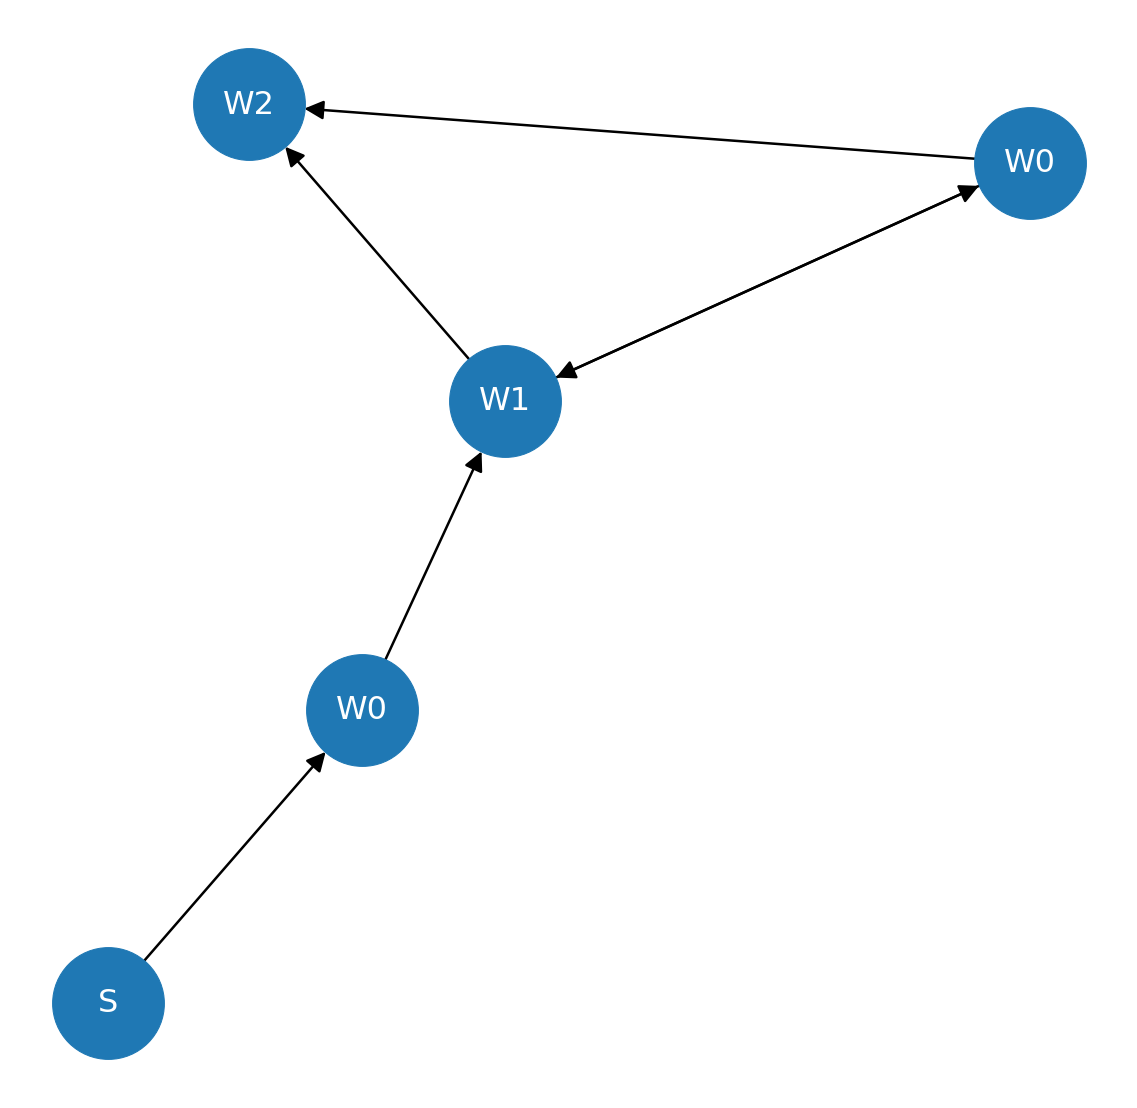

In [3]:
learner, evaluator, MDP = TrainAndEvalMDP(1, 'map')


Observe that the visiting sequence of nodes will always have '$W0$', '$W1$' and '$W2$' in that order. However, nodes already visited might be visited again. This agent will always obey $\varphi_3$ which is also the most restrictive formula.

### Maximum coverage ###

Training episode 999         

Size of the specification FSM:  11
Formulas considered:  3


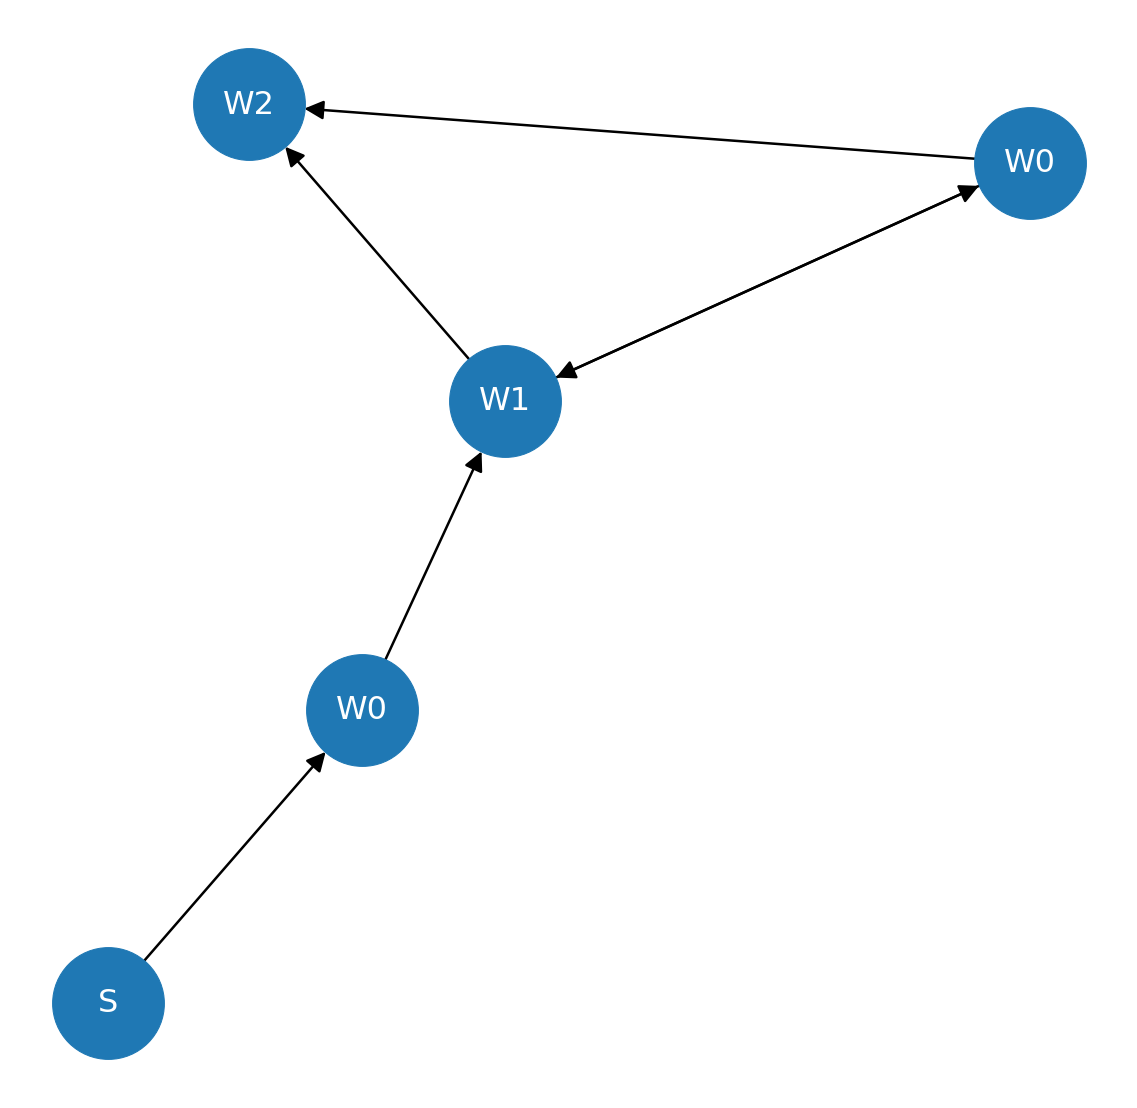

In [4]:
learner, evaluator, MDP = TrainAndEvalMDP(1, 'max_cover')

Unsurprisingly, even with the maximum coverage criterion, the same execution traces were explored. However note the larger size of the specification FSM as more formulas were considered during planning.

### Minimum regret

Training episode 999         

Size of the specification FSM:  11
Formulas considered:  3


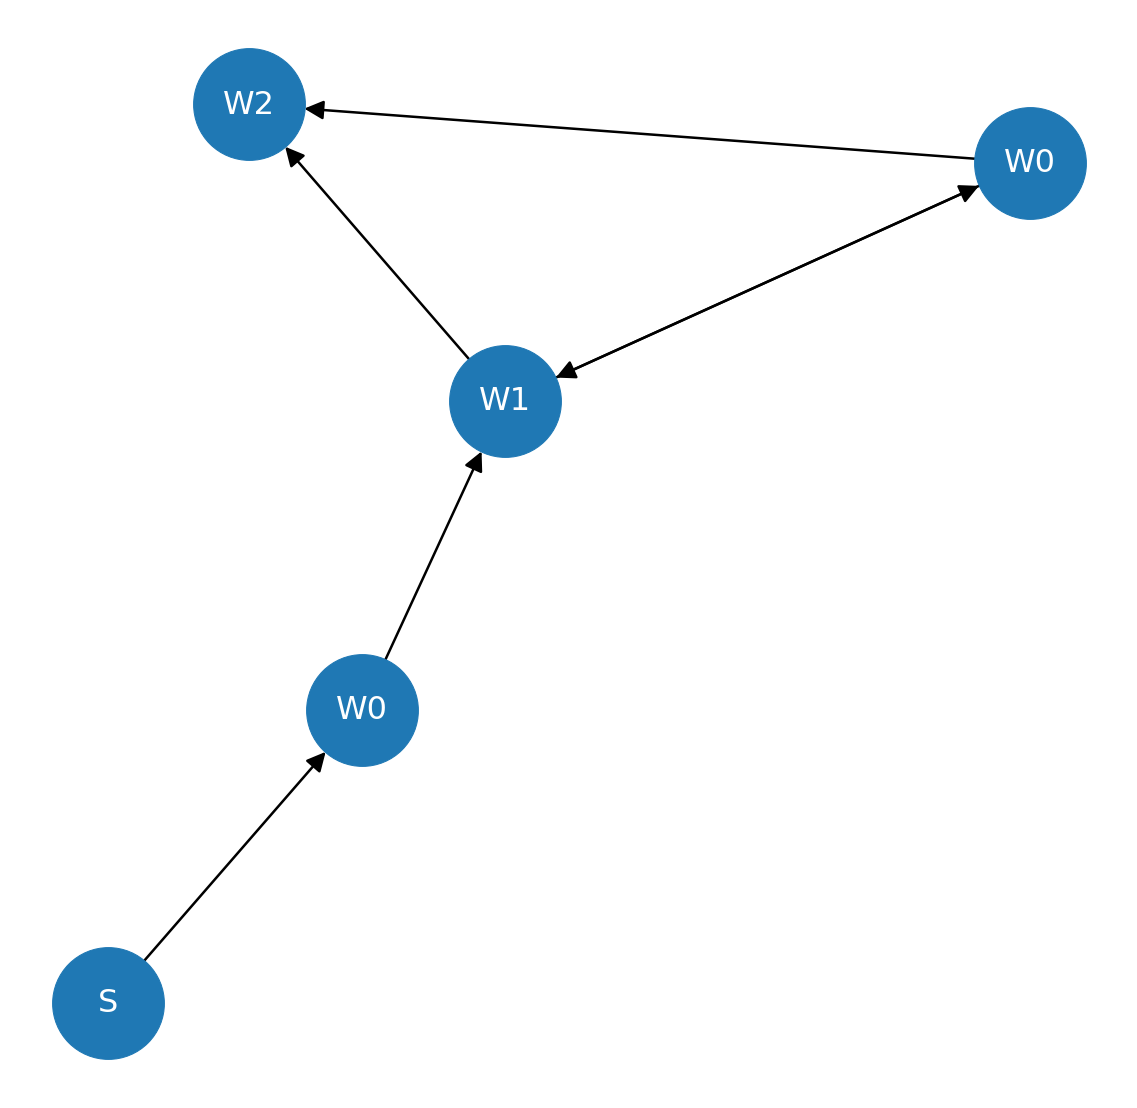

In [5]:
learner, evaluator, MDP = TrainAndEvalMDP(1, 'min_regret')

The perforamance is very similar to the maximum coverage criteria and the same number of FSM nodes. This is to be expected as both the max cover and minimum regret formulations construct the FSM with the same set of formulas, however the rewards are computed differently.

### Chance constrained ###

$\delta = 0.1$

Training episode 999         

Size of the specification FSM:  11
Formulas considered:  2


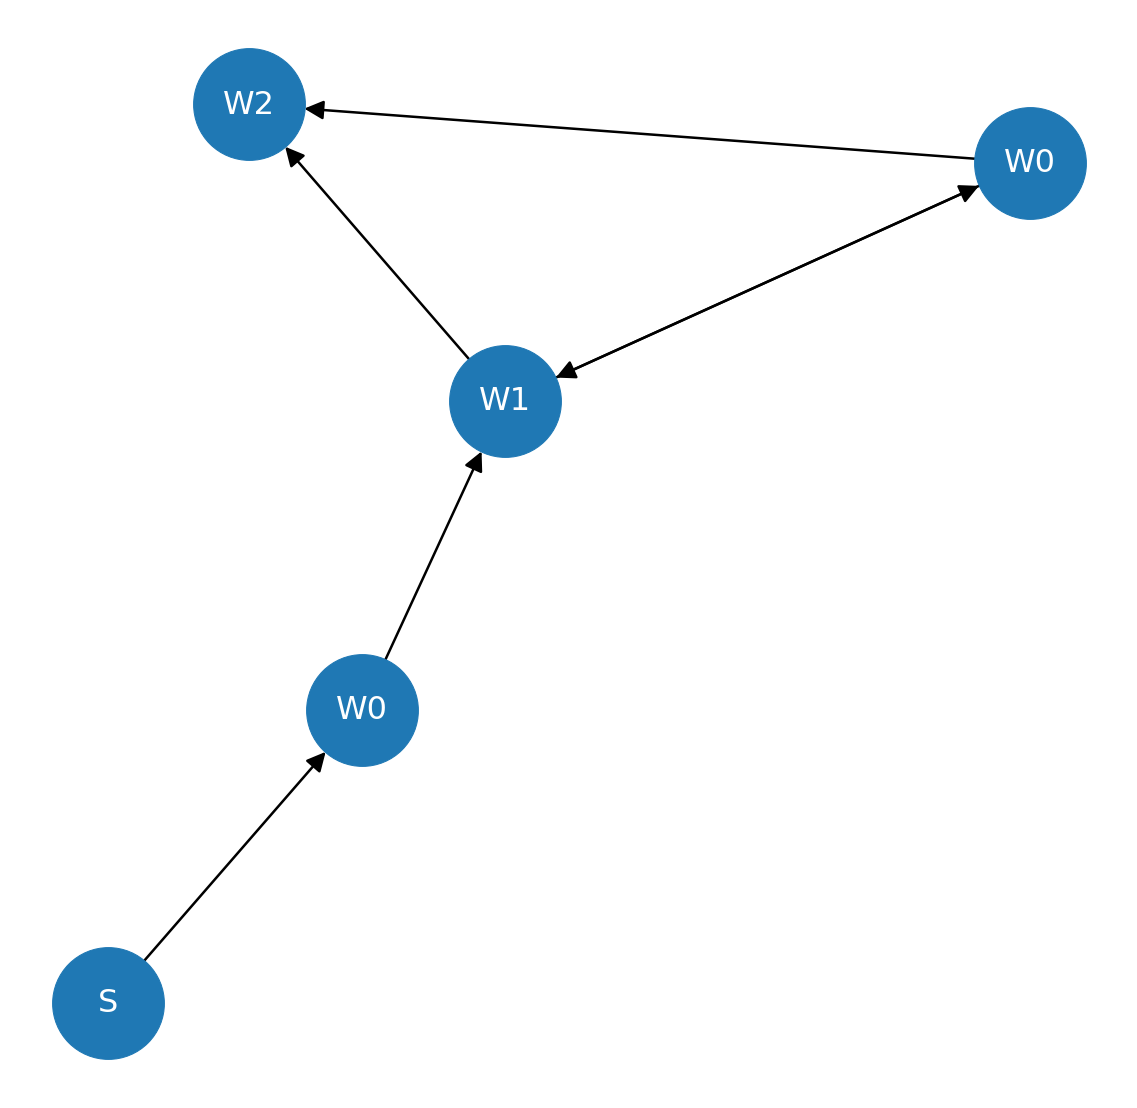

In [6]:
learner, evaluator, MDP = TrainAndEvalMDP(1, 'chance_constrained', risk_level = 0.1)

Not very surprising as the most likely formula is still satisfied. This is only considering two formulas to construct the FSM.

Setting $\delta = 0.45$

Training episode 999         

Size of the specification FSM:  5
Formulas considered:  1


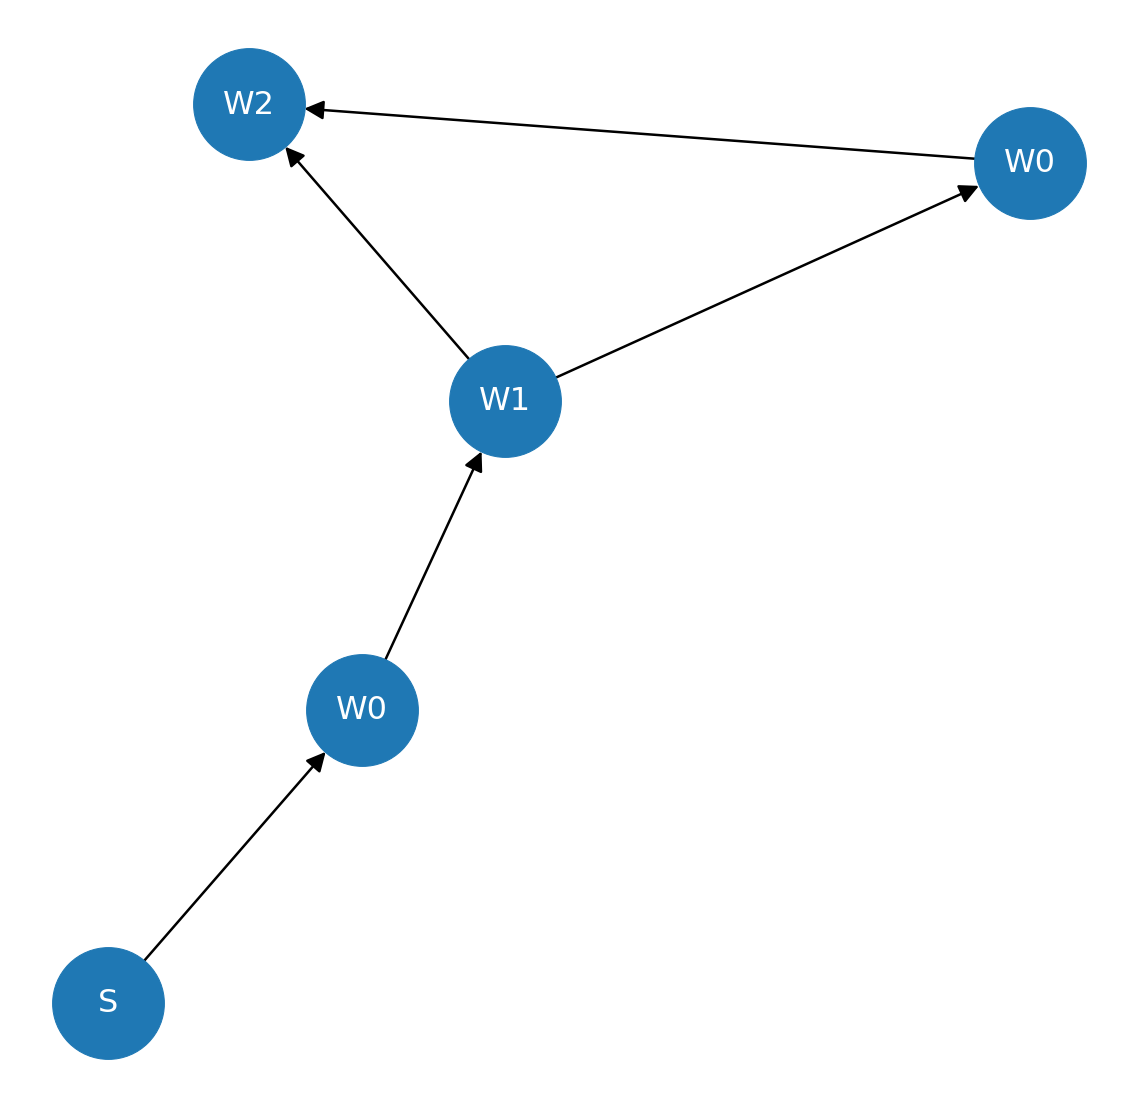

In [7]:
learner, evaluator, MDP = TrainAndEvalMDP(1, 'chance_constrained', risk_level = 0.45)

Note the smaller state machine and the fact that only one formula is now considered during planning.

## Case 2: Least restrictive formula is most likely ##

Consider the three formulas shown below:

$\varphi_1 = \mathbf{G} \neg T0 \wedge \mathbf{F} W0$  
$\varphi_2 =  \mathbf{G} \neg T0 \wedge \mathbf{F} W0 \wedge \mathbf{F} W1 \wedge \mathbf{F} W2$  
$\varphi_3 = \mathbf{G} \neg T0 \wedge \mathbf{F} W0 \wedge \mathbf{F} W1 \wedge \mathbf{F} W2 \wedge \neg W1 \mathbf{U} W0 \wedge \neg W2 \mathbf{U} W0 \wedge \neg W2 \mathbf{U} W1$  

$\varphi_1$ enforces that all of the nodes $W0$, $W1$ and $W2$ must be visited in that specific order. $\varphi_2$ requires that $W0$, $W1$ and $W2$ be visited but in any order. While $\varphi_3$ requires only $W0$ to be visited. All the formulas require $T0$ to never be visited. These formulas are associated with probabilities $[0.8, 0.15, 0.05]$. Thus the least restrictive formula is most likely as well.

### Most likely ###

Training episode 999         

Size of the specification FSM:  3
Formulas considered:  1


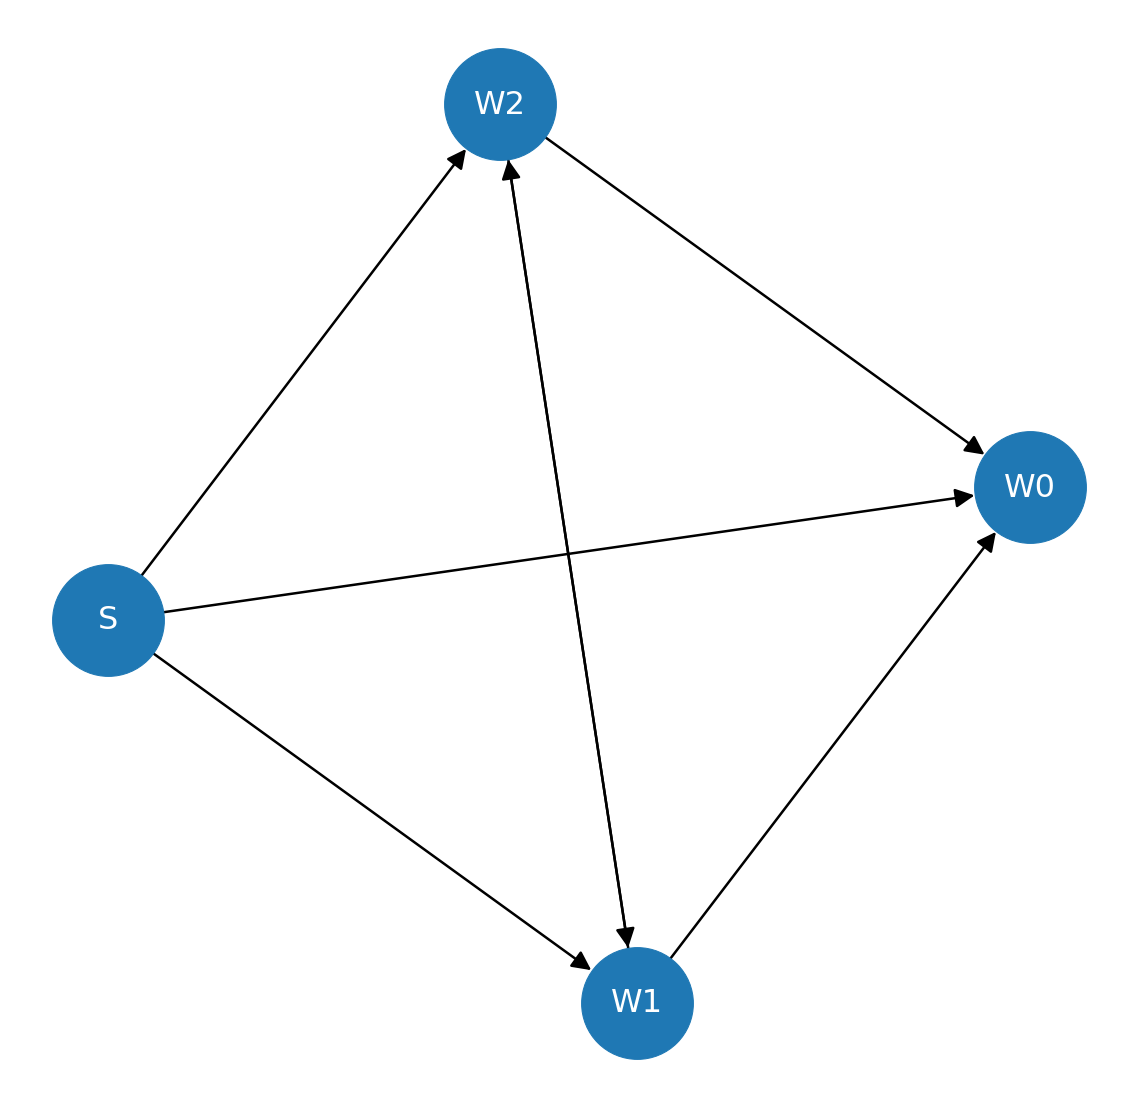

In [8]:
learner, evaluator, MDP = TrainAndEvalMDP(2, 'map')


Note that all executions end once '$W0$' was visited. This corresponds to satisfying $\varphi_3$.

### Maximum coverage ###

Training episode 999         

Size of the specification FSM:  11
Formulas considered:  3


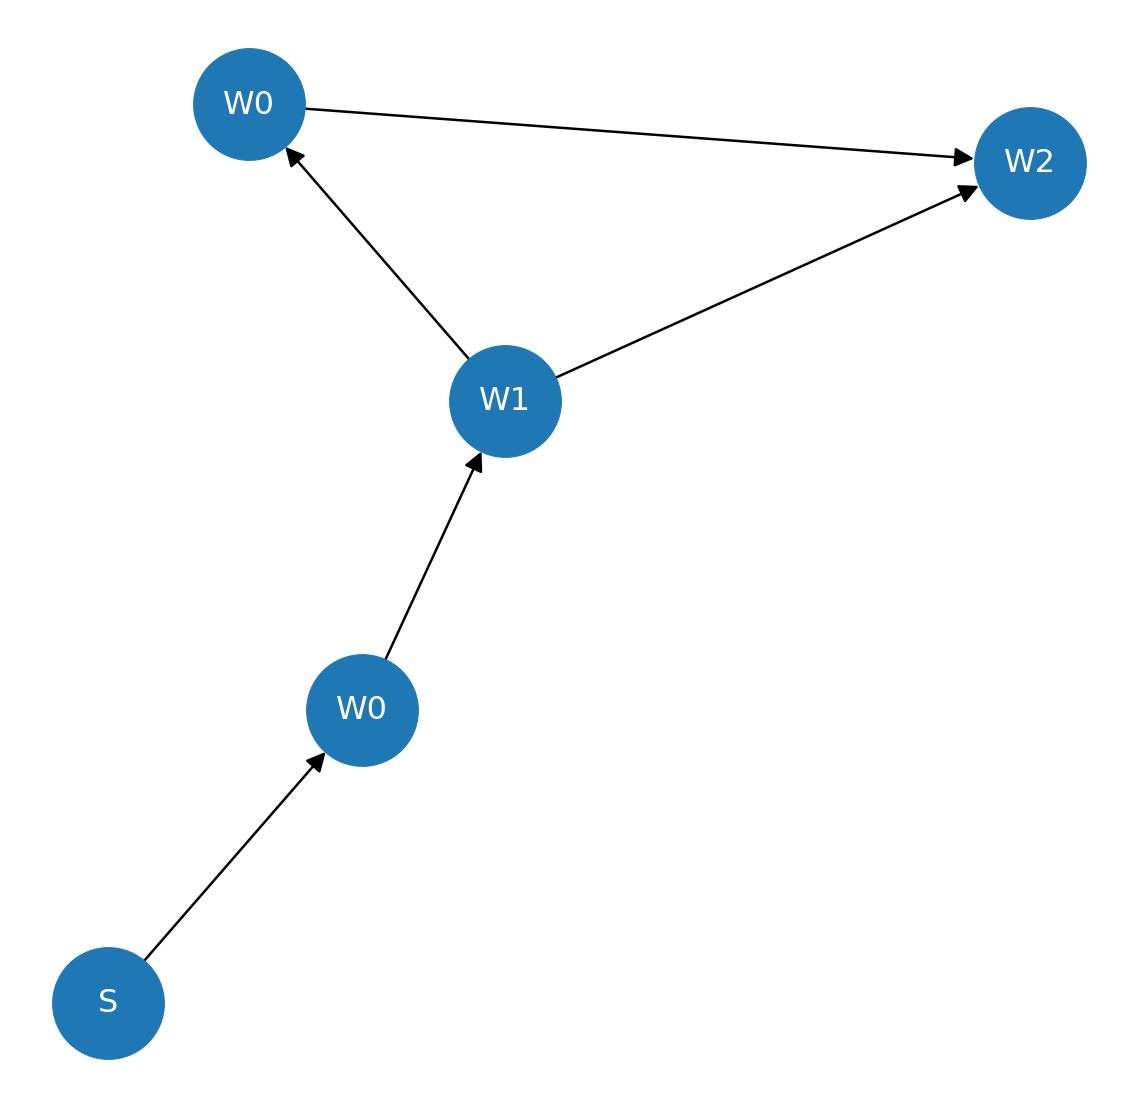

In [9]:
learner, evaluator, MDP = TrainAndEvalMDP(2, 'max_cover')

Under the max coverage policy, $\varphi_1$ is always satisfied as that automatically satisfies $\varphi_2$ and $\varphi_3$. Note that all formulas are used to construct the FSM.

Training episode 999         

Size of the specification FSM:  11
Formulas considered:  3
Average terminal reward:  0.9943
Median terminal reward:  1.0


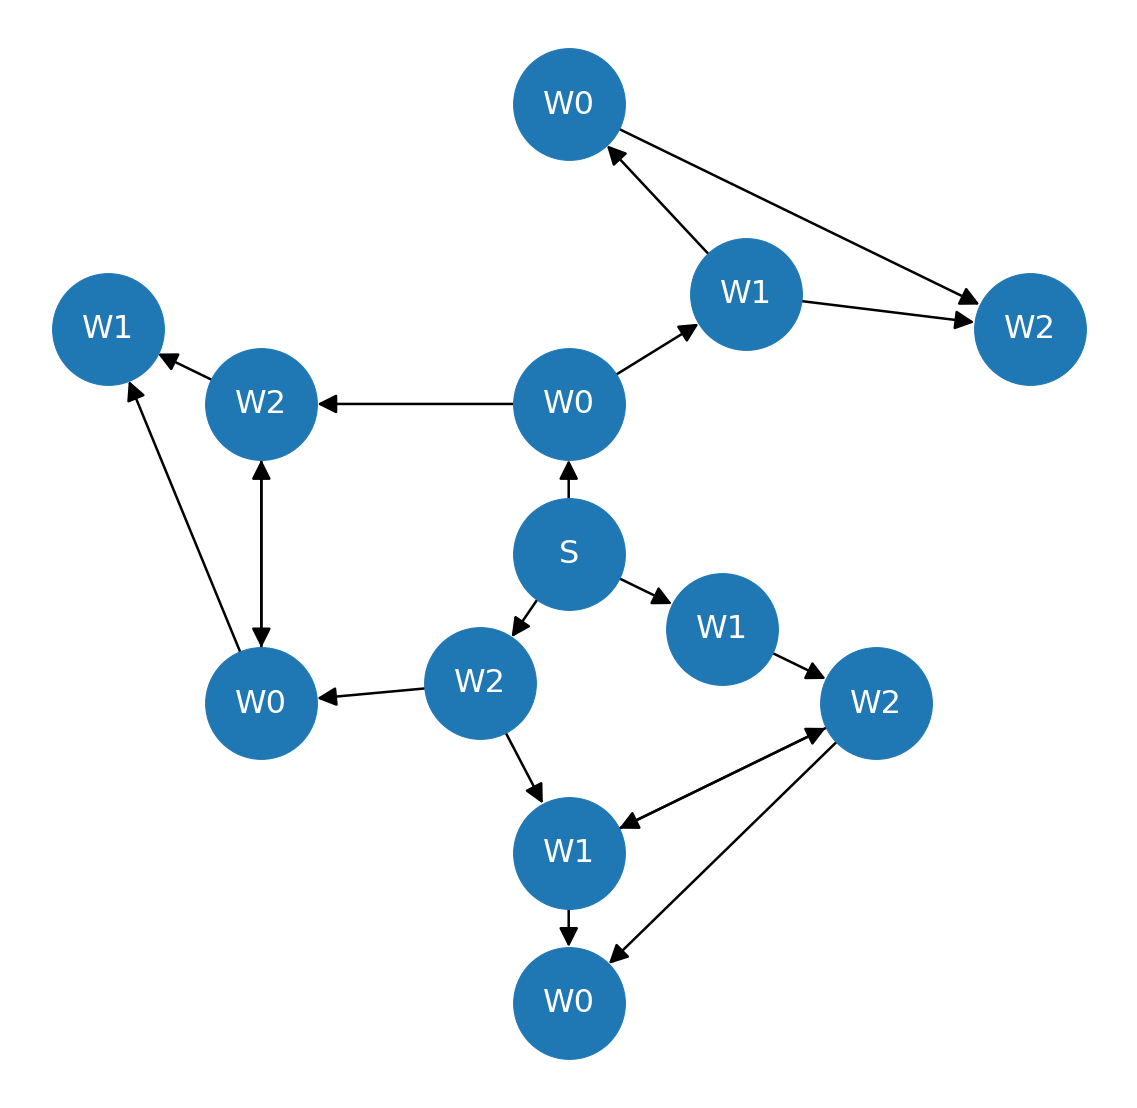

In [10]:
learner, evaluator, MDP = TrainAndEvalMDP(2, 'min_regret', print_terminal=True, prog='twopi')

As the most restrictive formulas only has a weight of 0.05, the agent explores other paths to performing the task and collecting suboptimal reward. However note that the average terminal reward was very close to $1$, so most of the executions satisfied all the formulas, and only some of the trajectories explored executions that did not satisfy $\varphi_3$.

### Chance constrained ###

$\delta = 0.1$

Training episode 999         

Size of the specification FSM:  9
Formulas considered:  2


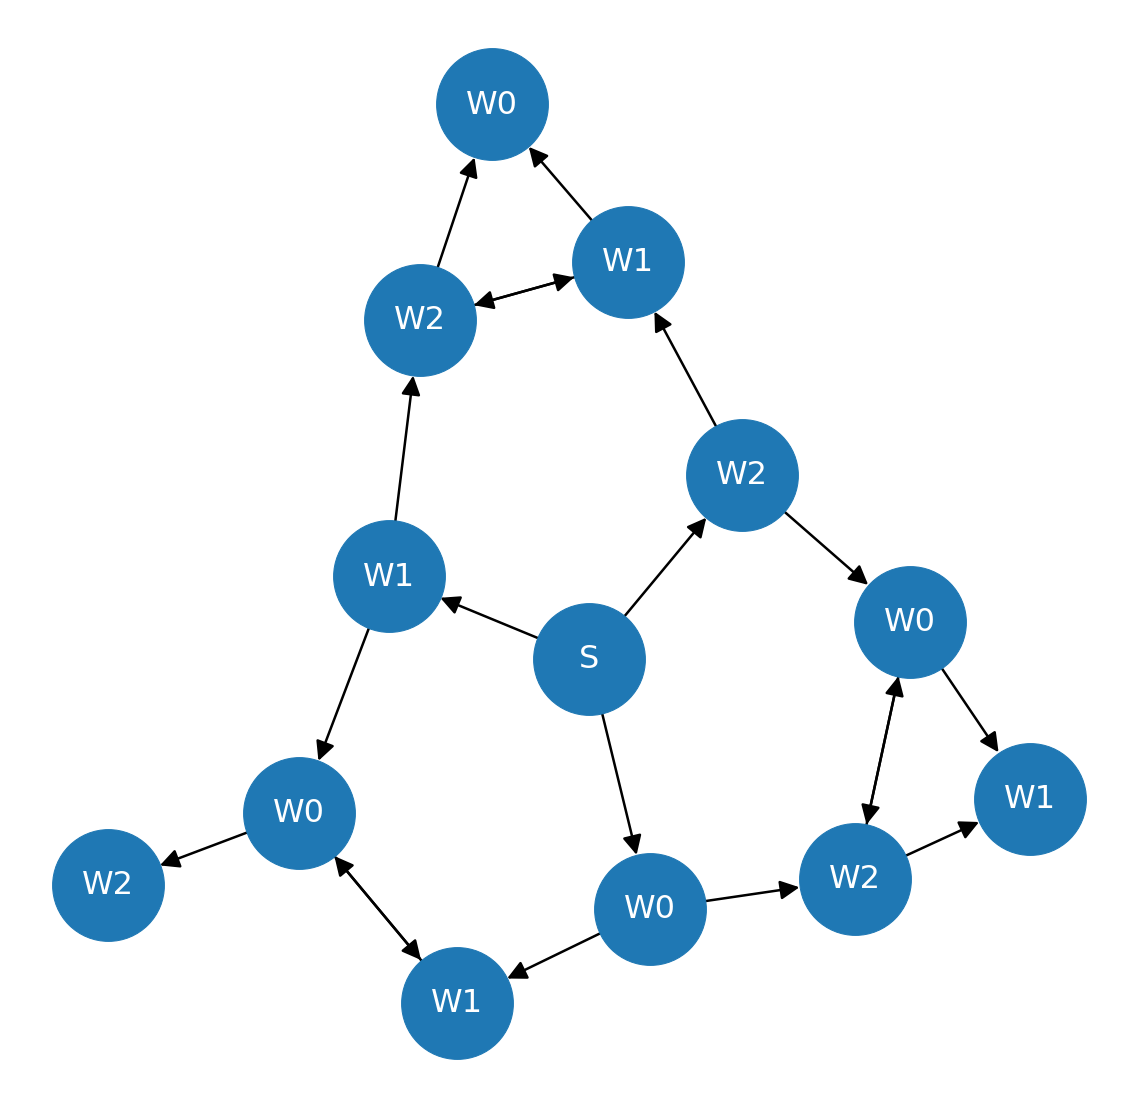

In [11]:
learner, evaluator, MDP = TrainAndEvalMDP(2, 'chance_constrained', risk_level = 0.1) 

Note that with $\delta = 0.1$, $\varphi_3$ is dropped from the specification set. Thus all possible visit orderings between '$W0$', '$W1$' and '$W2$' were explored.

$\delta = 0.3$

Training episode 999         

Size of the specification FSM:  3
Formulas considered:  1


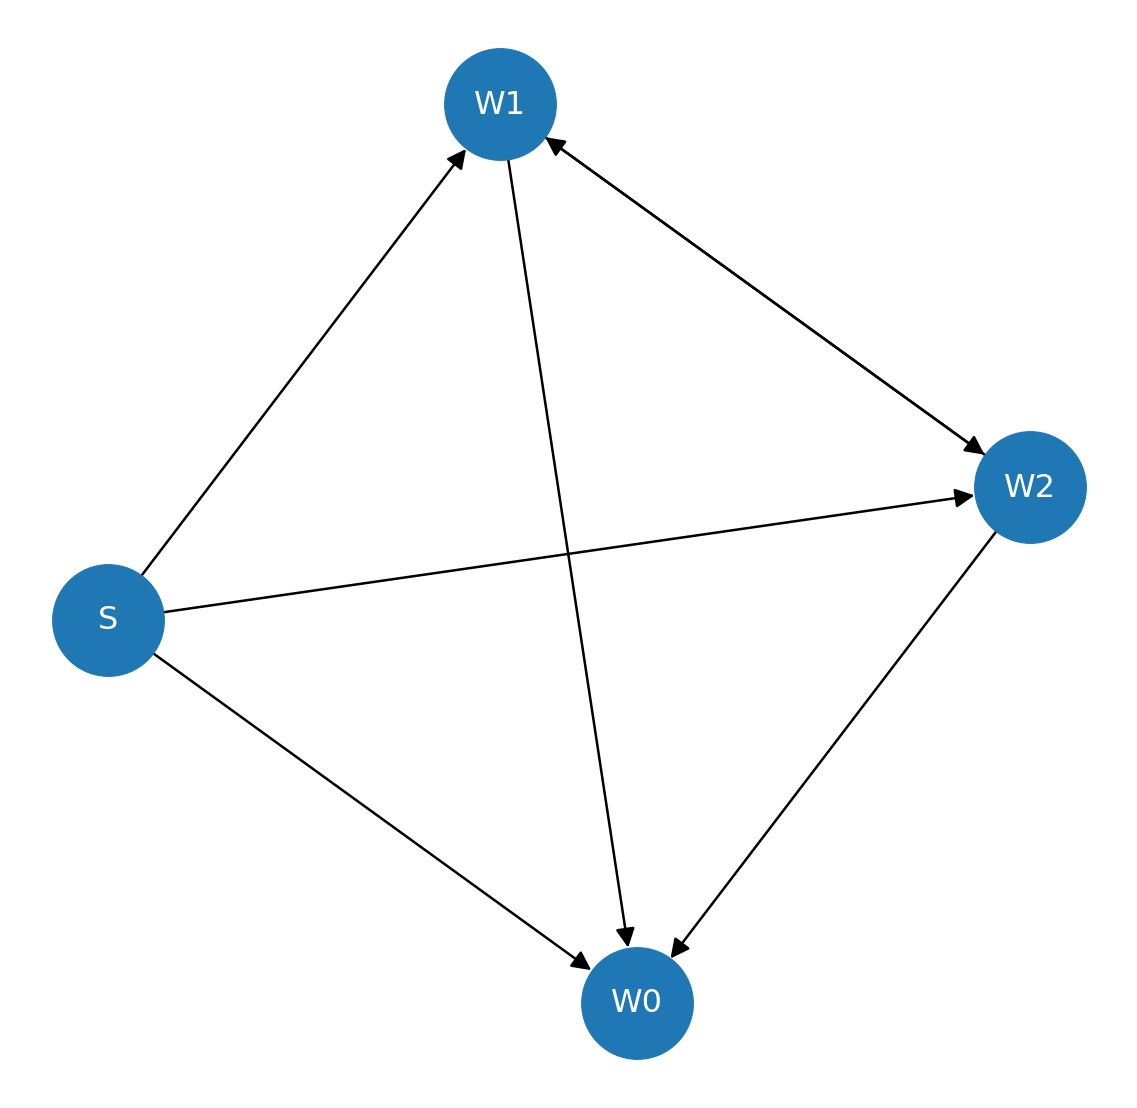

In [12]:
learner, evaluator, MDP = TrainAndEvalMDP(2, 'chance_constrained', risk_level = 0.3) 

Here only $\varphi_1$ is considered for planning. Thus the exploration graph is identical to the most likely criterion

## Case 3: Multiple formulas with a common set of satisfying executions ##

Consider the three formulas shown below:

$\varphi_1 = \mathbf{G} \neg T0 \wedge \mathbf{F} W0$  
$\varphi_2 = \mathbf{G} \neg T0 \wedge \mathbf{F} W1$  
$\varphi_3 = \mathbf{G} \neg T0 \wedge \mathbf{F} W2$  

Each formula requires that one of '$W0$', '$W1$' or '$W2$' be visited. However visiting all of them would satisfy all the formulas. The associated probabilities are $[0.4, 0.25, 0.35]$ respectively

### Most likely ###

Training episode 999         

Size of the specification FSM:  3
Formulas considered:  1


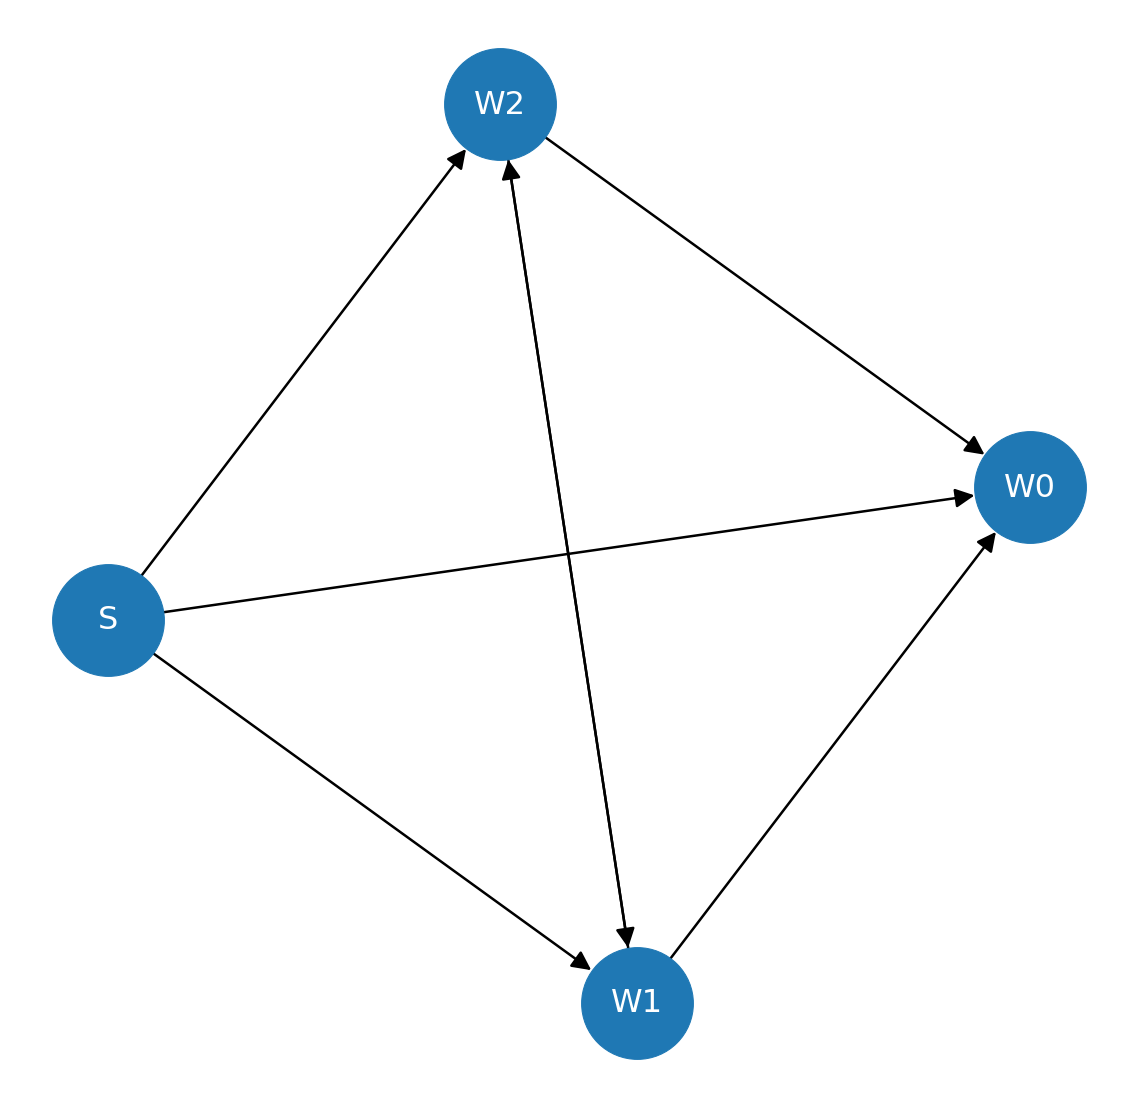

In [13]:
learner, evaluator, MDP = TrainAndEvalMDP(3, 'map') 

In all the executions only $W0$ was visited as expected.

### Max coverage ###

Training episode 999         

Size of the specification FSM:  9
Formulas considered:  3


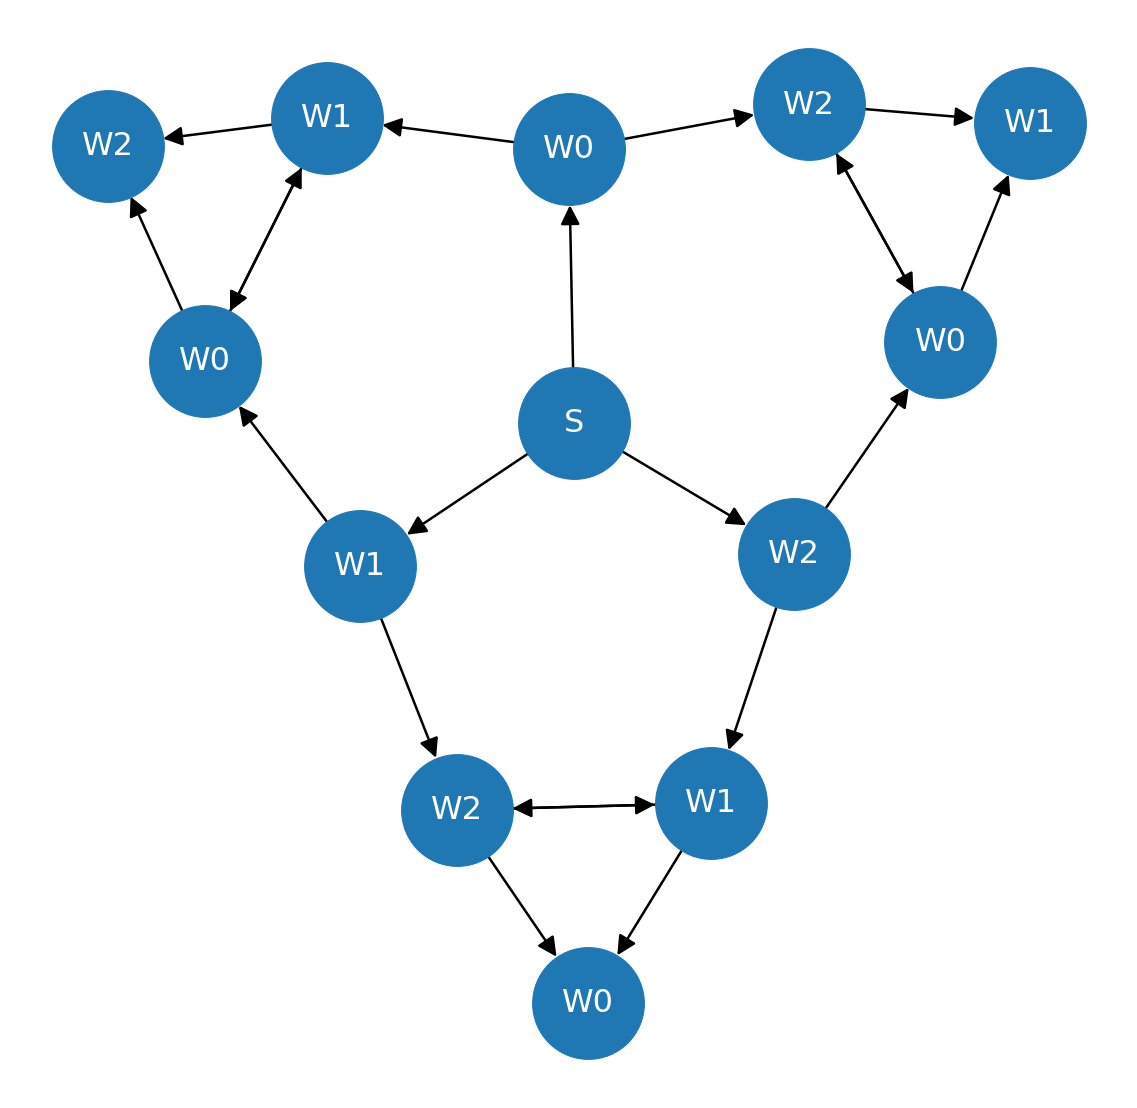

In [14]:
learner, evaluator, MDP = TrainAndEvalMDP(3, 'max_cover') 

As expected all the nodes were visited with all possible orderings.

### Minimum regret ###

Training episode 999         

Size of the specification FSM:  9
Formulas considered:  3


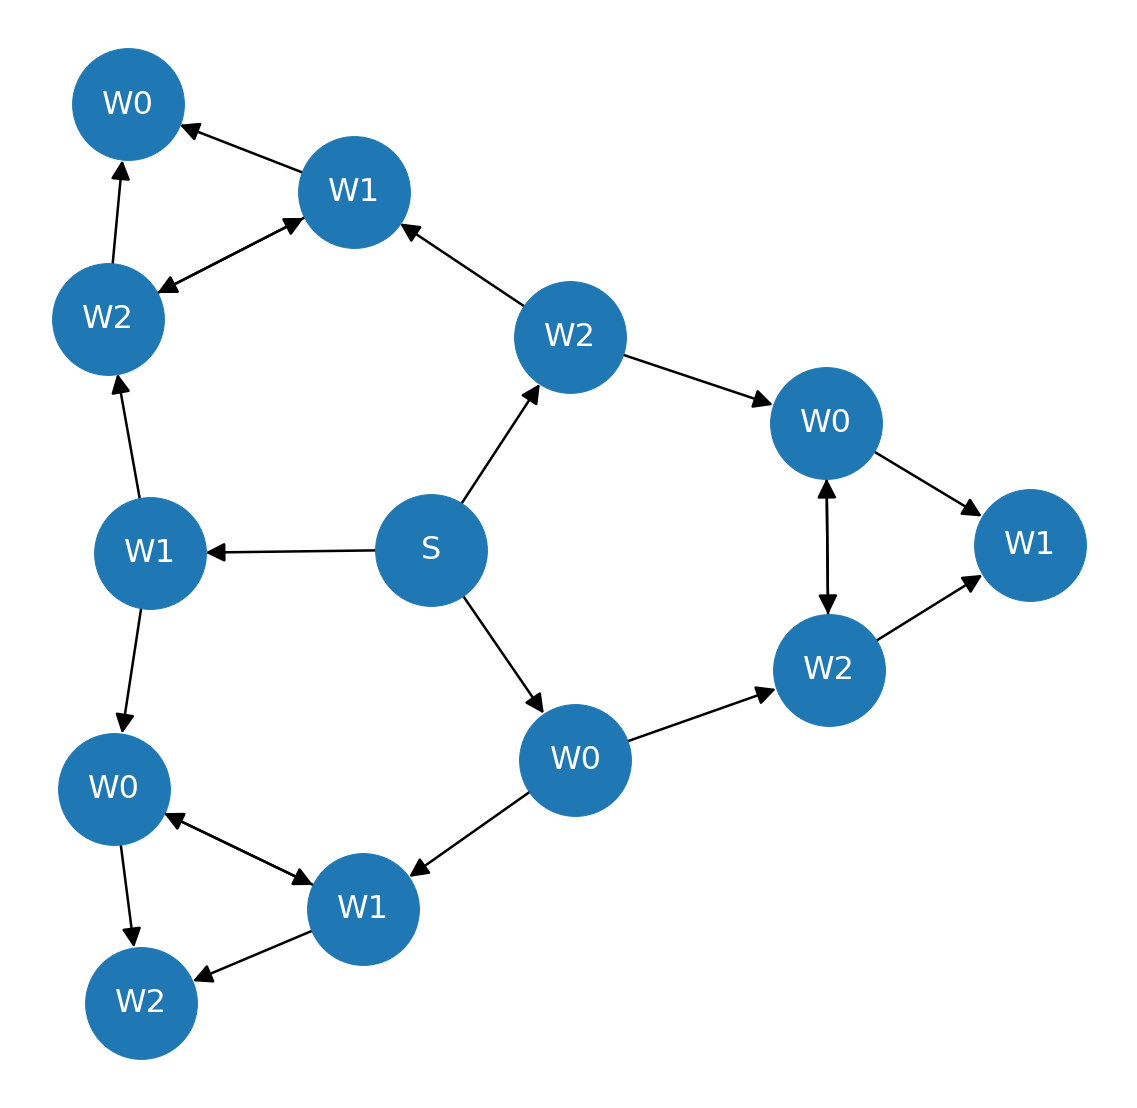

In [15]:
learner, evaluator, MDP = TrainAndEvalMDP(3, 'max_cover') 

As the probability weights are similar, this is virtually identical to maximum coverage

### Chance constrained ###

$\delta = 0.3$

Training episode 999         

Size of the specification FSM:  5
Formulas considered:  2


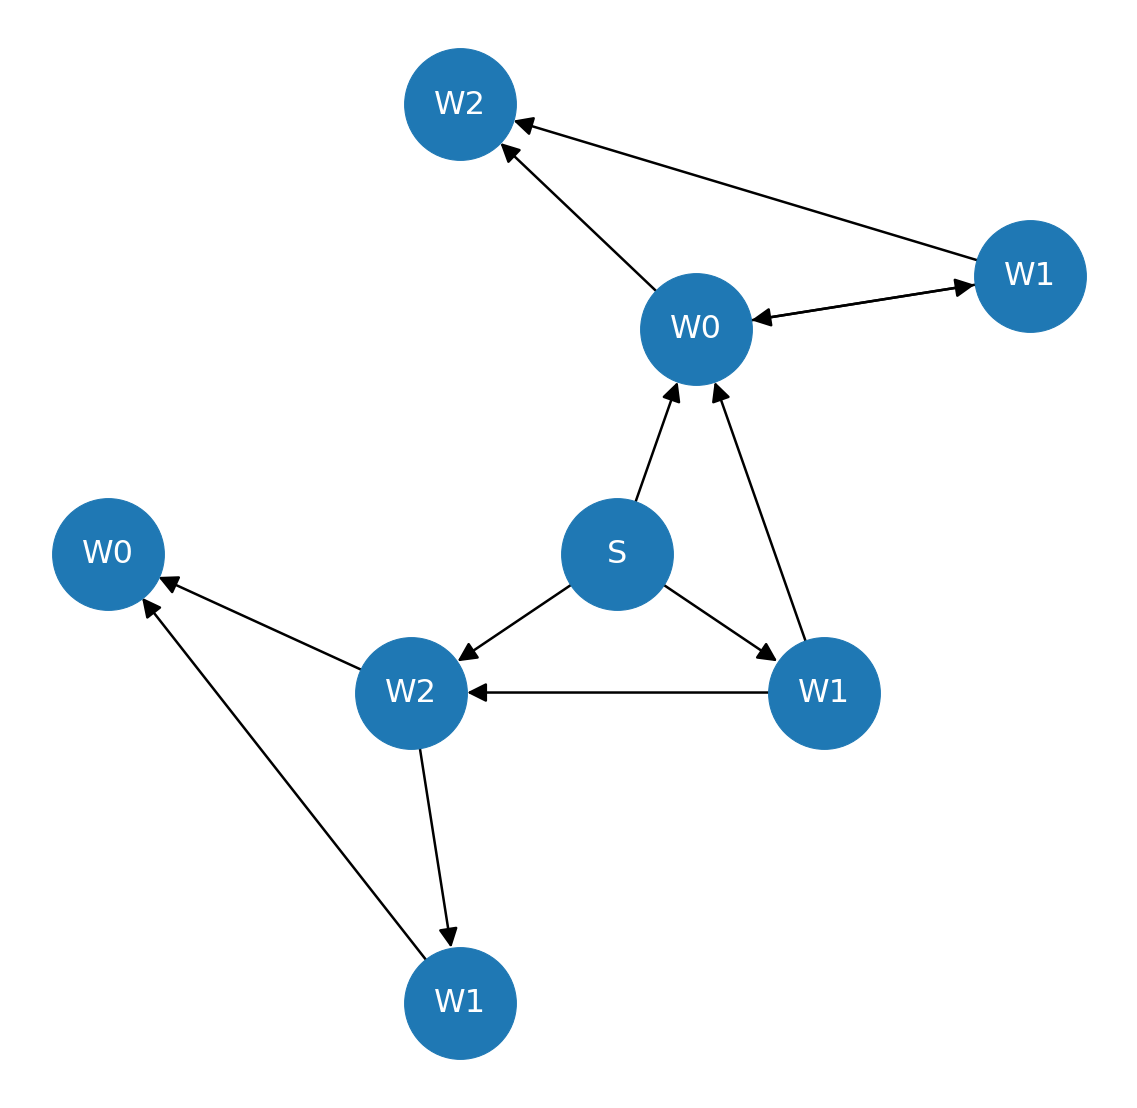

In [16]:
learner, evaluator, MDP = TrainAndEvalMDP(3, 'chance_constrained', risk_level = 0.3, prog='twopi') 

Note that there are only 2 formulas considered in the specification set. All executions necessarily visit '$W0$' and '$W2$'

$\delta = 0.65$

Training episode 999         

Size of the specification FSM:  3
Formulas considered:  1


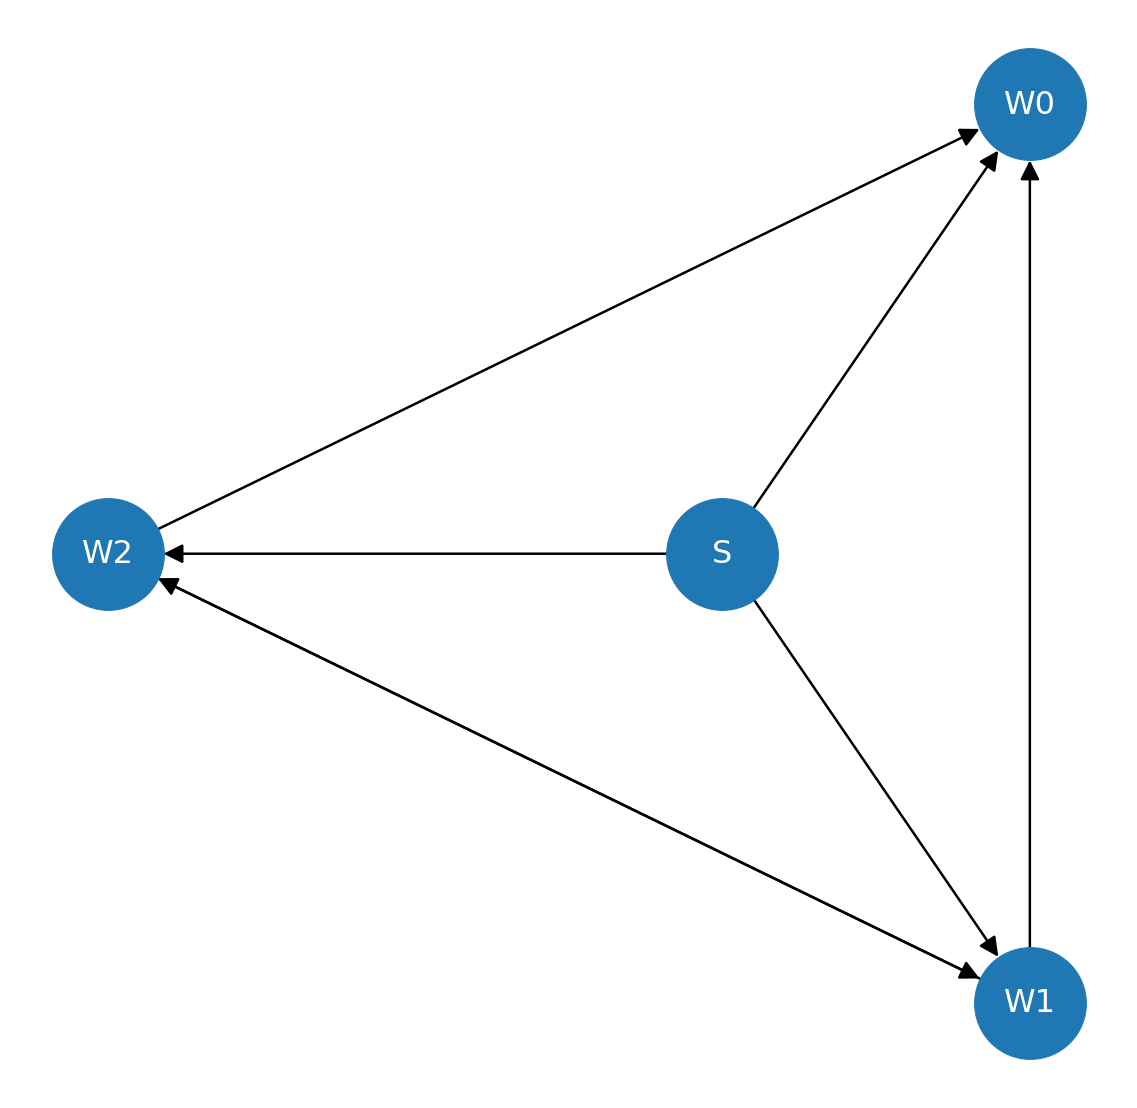

In [17]:
learner, evaluator, MDP = TrainAndEvalMDP(3, 'chance_constrained', risk_level = 0.65, prog='twopi') 

Only a single formula is considered and all executions necessarily visit '$W0$'

## Case 4: No common set of executions ###

Consider the three formulas shown below:

$\varphi_1 = \mathbf{G} \neg T0 \wedge \mathbf{G} \neg W2 \wedge \mathbf{F} W0$  
$\varphi_2 = \mathbf{G} \neg T0 \wedge \mathbf{G} \neg W2 \wedge \mathbf{F} W1$  
$\varphi_3 = \mathbf{G} \neg T0 \wedge \mathbf{F} W2$  

The first two formulas require that '$W0$' and '$W1$' be visited but '$W2$' never be visited. $\varphi_3$ requires that '$W2$' should be visited. Thus if $\varphi_1$ or $\varphi_2$ are satisfied, $\varphi_3$ cannot be satisfied and vice-versa The associated probabilities are $[0.05, 0.15, 0.8]$ respectively

### Most likely ###

Training episode 168         

Training episode 828         

Training episode 357         

Training episode 925         

Training episode 999         

Size of the specification FSM:  3
Formulas considered:  1


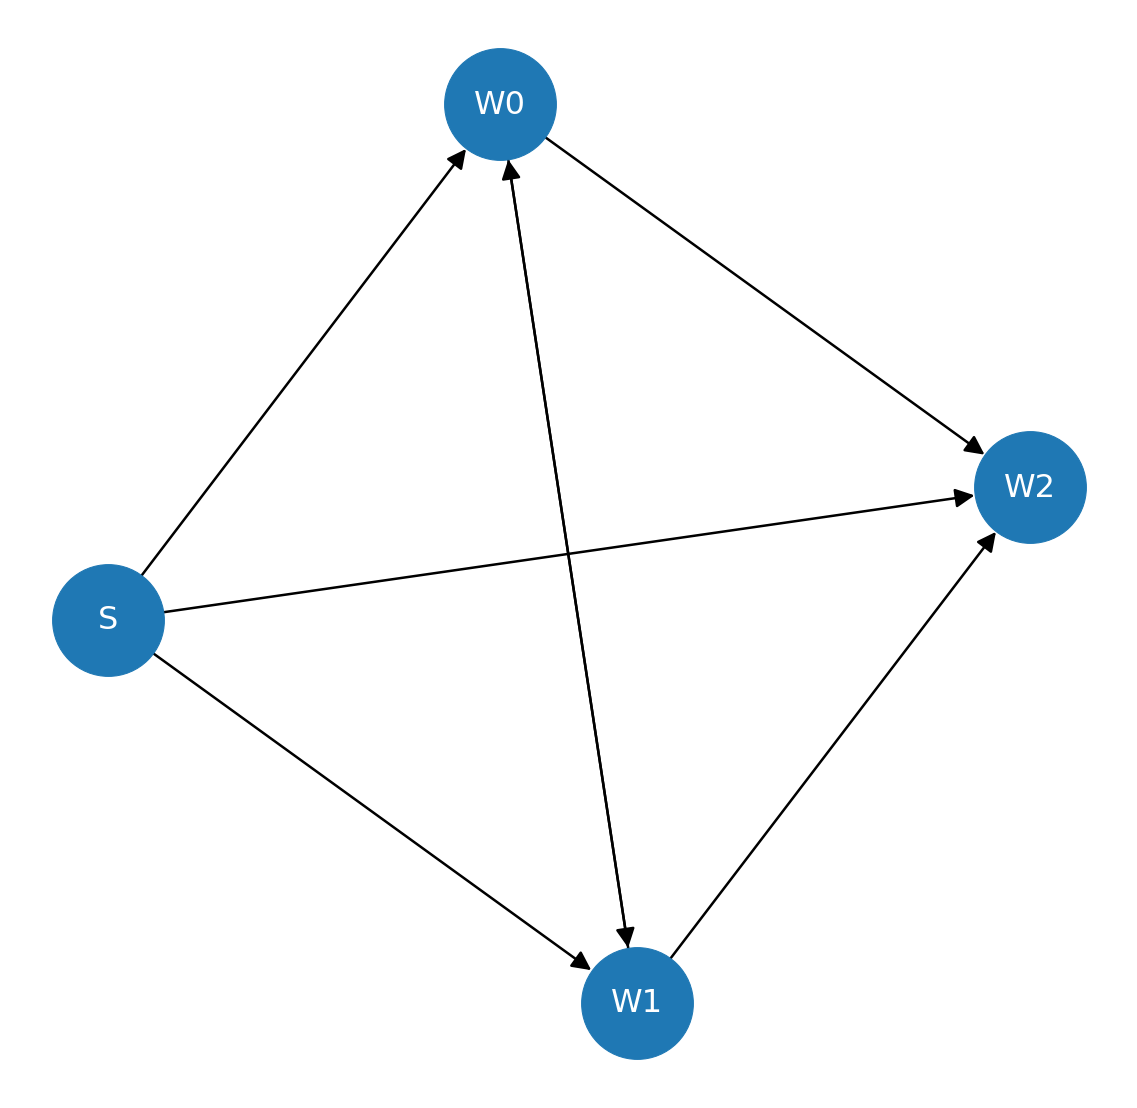

In [18]:
learner, evaluator, MDP = TrainAndEvalMDP(4, 'map') 

The planner only plans with the 1 formula $\varphi_3$ and completely ignores the other two.

### Maximum coverage ###

Training episode 499         

Size of the specification FSM:  6
Formulas considered:  3


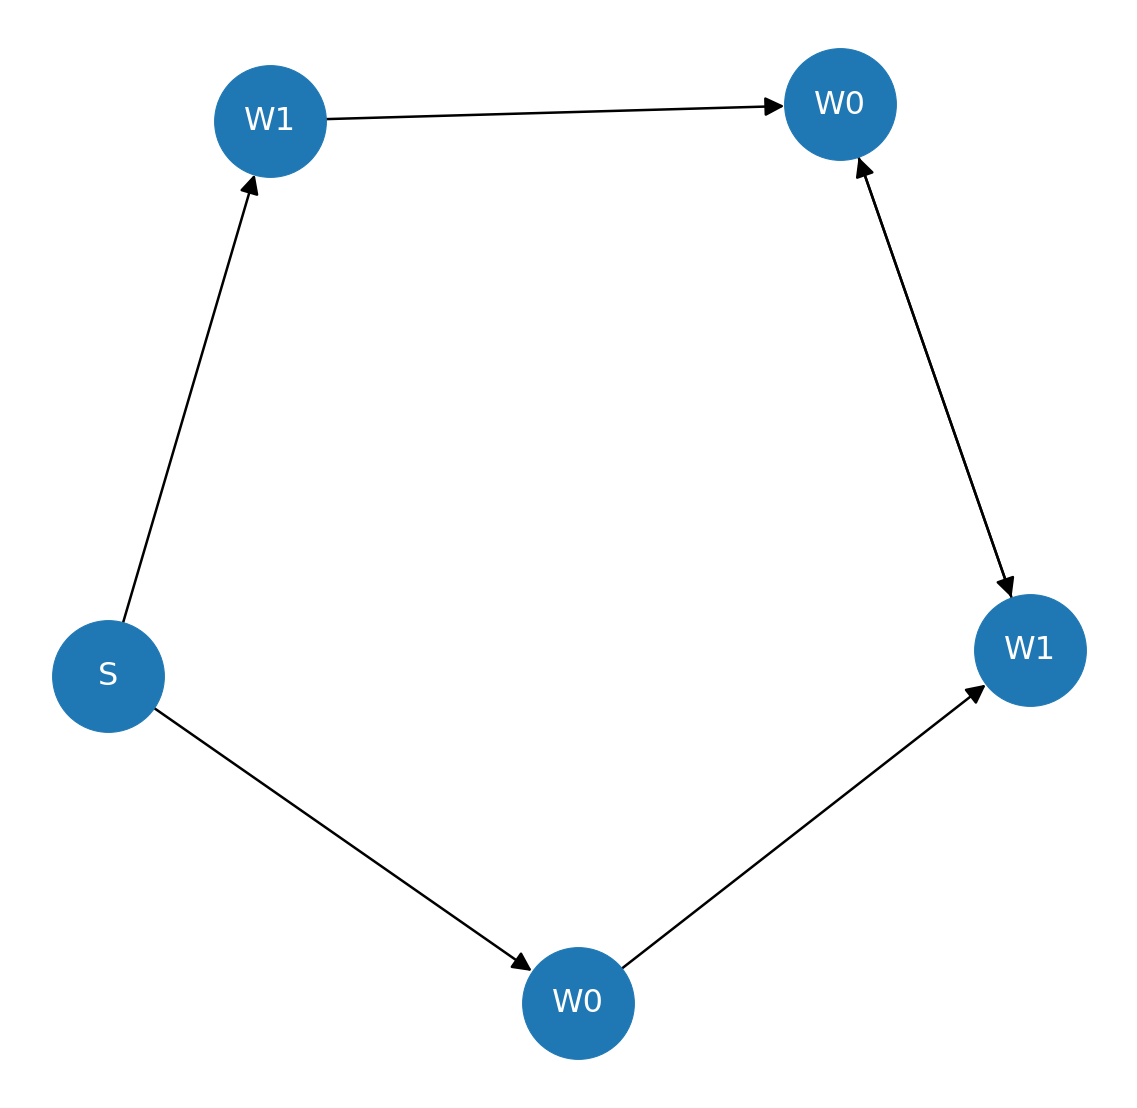

In [19]:
learner, evaluator, MDP = TrainAndEvalMDP(4, 'max_cover') 

While all three formulas are considered, the planner chooses to satisfy only $\varphi_1$ and $\varphi_2$ as they both can be simultaneously satisfied. It chooses not to satisfy $\varphi_3$.

### Minimum regret ###

Training episode 999         

Size of the specification FSM:  6
Formulas considered:  3


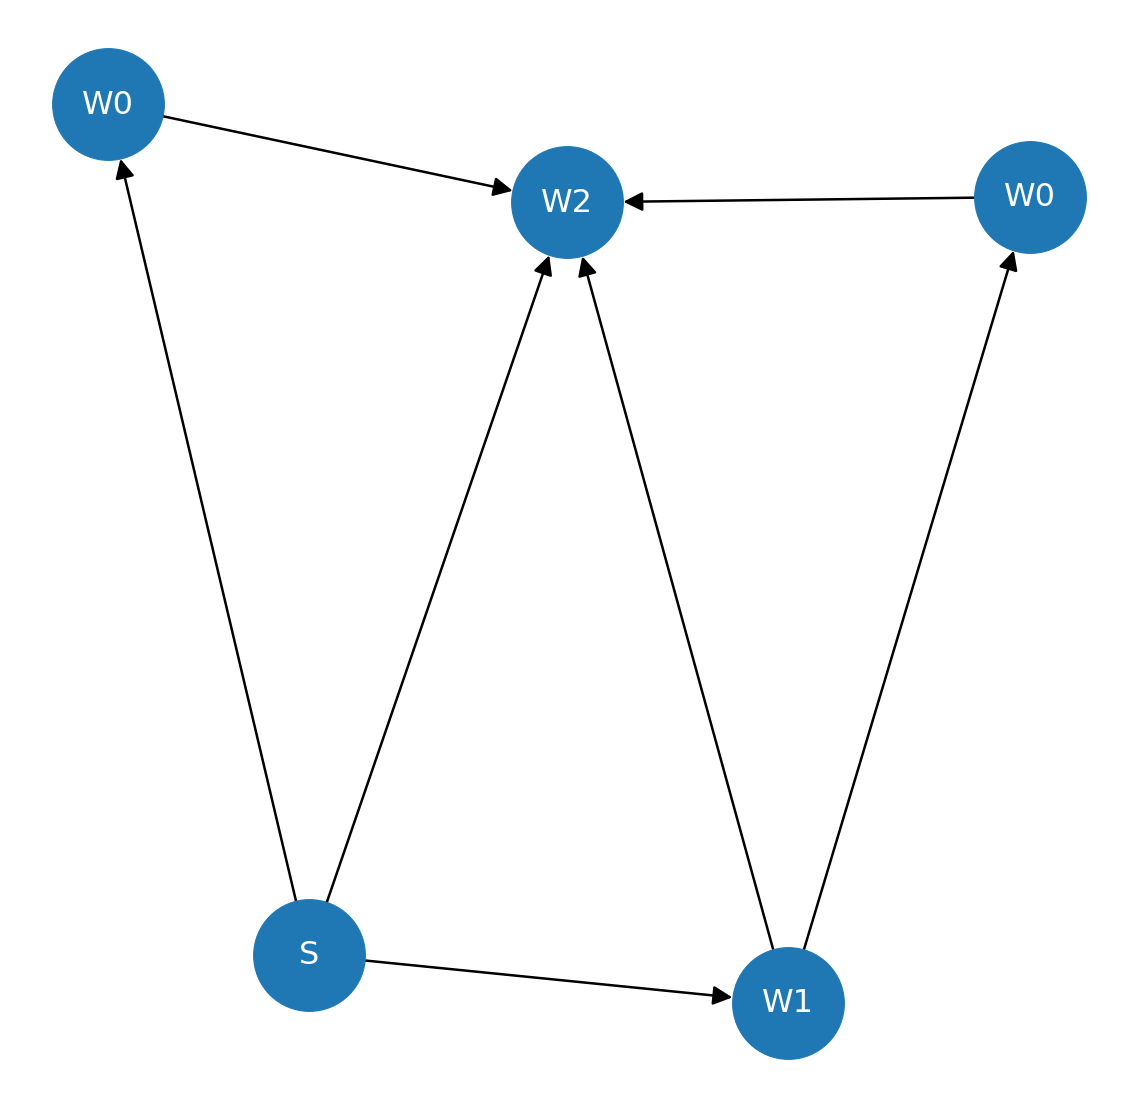

In [20]:
learner, evaluator, MDP = TrainAndEvalMDP(4, 'min_regret') 

Under this, the planner necessarily visits '$W2$' thus not satisfying $\varphi_1$ and $\varphi_2$. This is because $P(\varphi_1) + P(\varphi_2) < P(\varphi_3)$ thus under the minimum regret formulation, satisfying $\varphi_3$ yields a higher reward.

### Chance constrained ###

$\delta = 0.3$

Training episode 999         

Size of the specification FSM:  4
Formulas considered:  2


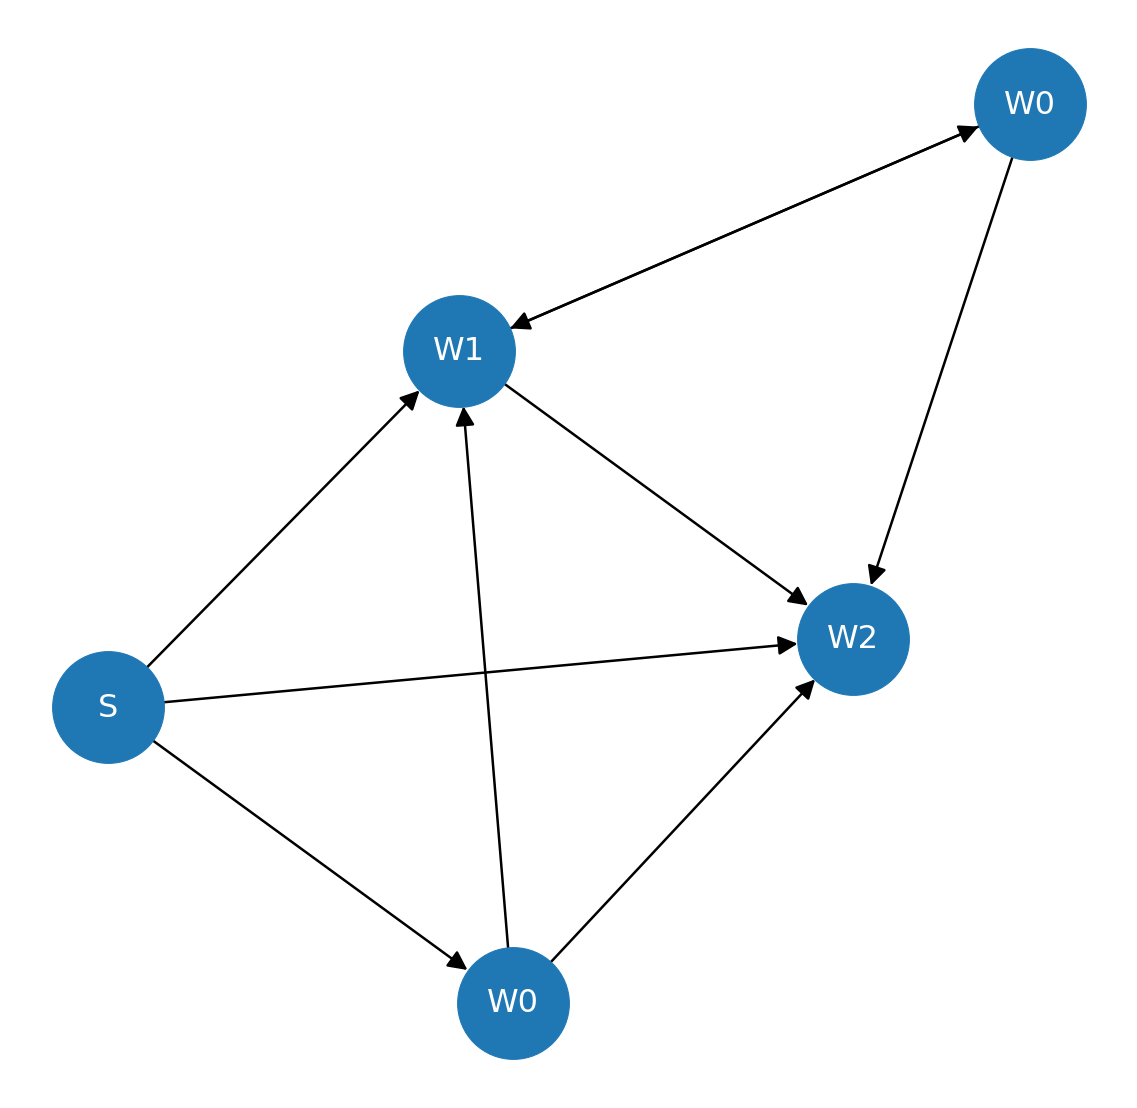

In [21]:
learner, evaluator, MDP = TrainAndEvalMDP(4, 'chance_constrained', risk_level=0.15) 

Here as $\varphi_3$ is the highest weighted formula, even under the chance constrained criteria, it is always satisfied.